In [142]:
import requests
import pandas as pd

api_key = 'ITL1B9MC4L5G7SEN'
symbol = 'SIE.DE'
output_size = 'full'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={output_size}&apikey={api_key}'
r = requests.get(url)
time_series = r.json()['Time Series (Daily)']

data = []
for date, values in time_series.items():
    data.append([
        date,
        float(values["1. open"]),
        float(values["2. high"]),
        float(values["3. low"]),
        float(values["4. close"]),
        int(values["5. volume"])
    ])

df0 = pd.DataFrame(data, columns=["date", "open", "high", "low", "close", "volume"])
print(df0.shape)
df0.head(15)

(4943, 6)


,date,open,high,low,close,volume
0,2024-06-14,170.80,171.10,165.68,165.74,1686923
1,2024-06-13,177.28,177.56,170.44,170.84,1395794
2,2024-06-12,173.12,178.58,172.30,178.10,975006
3,2024-06-11,174.70,175.44,172.18,172.46,953042
4,2024-06-10,174.12,174.52,172.06,174.44,717411
5,2024-06-07,175.00,175.26,172.62,174.44,1034765
6,2024-06-06,178.88,179.52,175.14,175.68,826573
7,2024-06-05,175.60,178.82,175.38,178.82,828300
8,2024-06-04,178.58,179.00,174.28,174.28,1232510
9,2024-06-03,178.80,179.60,177.10,178.16,745486


In [143]:
import pandas_ta as pta
import ta

df = df0.copy()

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df['RSI'] = pta.rsi(df['close'], length=11)
df['William%R'] = pta.willr(df['high'], df['low'], df['close'], length=11)
df['WMA'] = pta.wma(df['close'], length=11)
df['EMA'] = pta.ema(df['close'], length=11)
df['SMA'] = pta.sma(df['close'], length=11)
df['HMA'] = pta.hma(df['close'], length=11)
df['CCI'] = pta.cci(df['high'], df['low'], df['close'], length=11)
df['CMO'] = pta.cmo(df['close'], length=11)

macd = pta.macd(df['close'])
df['MACD'] = macd.iloc[:, 0] 
df['MACD_signal'] = macd.iloc[:, 1] 

ppo = pta.ppo(df['close'])
df['PPO'] = ppo.iloc[:, 0] 
df['PPO_signal'] = ppo.iloc[:, 1]

df['ROC'] = pta.roc(df['close'], length=11)
df['CMFI'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=11).chaikin_money_flow()

dmi = pta.adx(df['high'], df['low'], df['close'], length=11)
df['DMI'] = dmi['ADX_11']
df['DI+'] = dmi['DMP_11']
df['DI-'] = dmi['DMN_11']

df['PSI'] = pta.pvt(df['close'], df['volume'])
df['TripleEMA'] = pta.ema(df['close'], length=11)

def label_data(data, window_size=11):
    data['Label'] = 'Hold'
    for i in range(window_size, len(data) - window_size):
        window = data['Close'].iloc[i-window_size:i+window_size]
        min_index = window.idxmin()
        max_index = window.idxmax()
        if i == min_index:
            data.at[i, 'Label'] = 'Buy'
        elif i == max_index:
            data.at[i, 'Label'] = 'Sell'
    return data

df = df.dropna()

for column in df.columns:
    df[column] = (df[column] - df[column].mean()) / df[column].std()

df = df.drop(columns=['MACD_signal', 'PPO_signal', 'DI+', 'DI-'])

print(df.info())
df.head(15)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4910 entries, 2024-04-29 to 2005-01-03
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       4910 non-null   float64
 1   high       4910 non-null   float64
 2   low        4910 non-null   float64
 3   close      4910 non-null   float64
 4   volume     4910 non-null   float64
 5   RSI        4910 non-null   float64
 6   William%R  4910 non-null   float64
 7   WMA        4910 non-null   float64
 8   EMA        4910 non-null   float64
 9   SMA        4910 non-null   float64
 10  HMA        4910 non-null   float64
 11  CCI        4910 non-null   float64
 12  CMO        4910 non-null   float64
 13  MACD       4910 non-null   float64
 14  PPO        4910 non-null   float64
 15  ROC        4910 non-null   float64
 16  CMFI       4910 non-null   float64
 17  DMI        4910 non-null   float64
 18  PSI        4910 non-null   float64
 19  TripleEMA  4910 non-null   flo

,open,high,low,close,volume,RSI,William%R,WMA,EMA,SMA,HMA,CCI,CMO,MACD,PPO,ROC,CMFI,DMI,PSI,TripleEMA
date,,,,,,,,,,,,,,,,,,,,
2024-04-29,3.076558,3.043858,3.092136,3.050147,-1.005469,0.029870,-0.774977,3.092911,3.082873,3.160439,2.934508,-0.360760,0.029870,0.818661,0.725794,-0.867154,0.593130,0.008023,-1.165691,3.082873
2024-04-26,2.963077,3.014868,2.982005,3.049468,-0.845337,0.026385,-0.779657,3.072712,3.076234,3.136978,2.953291,-0.487545,0.026385,0.707791,0.528790,-0.661845,1.416329,0.045257,-1.165778,3.076234
2024-04-25,2.951525,2.913741,2.909497,2.916455,-0.787360,-0.594655,-1.350263,3.034277,3.048549,3.093012,2.952033,-0.998797,-0.594655,0.428106,0.368749,-1.235735,1.475481,0.143473,-1.185216,3.048549
2024-04-24,2.960359,2.969024,2.973113,2.948351,-0.795461,-0.399684,-0.967255,3.008489,3.030790,3.050646,2.944068,-0.647311,-0.399684,0.249877,0.155636,-1.187467,0.676465,0.132887,-1.180532,3.030790
2024-04-23,2.948807,2.934641,2.960116,2.972104,-0.841508,-0.252206,-0.693016,2.993725,3.019946,3.023737,2.938124,-0.639262,-0.252206,0.141782,-0.059429,-0.766367,0.770860,0.136656,-1.177409,3.019946
2024-04-22,2.959679,2.940708,2.962168,2.927313,-0.921940,-0.473476,-0.880974,2.975991,3.003450,3.000461,2.926844,-0.642100,-0.473476,-0.005950,-0.216458,-0.670062,0.627685,0.128352,-1.182139,3.003450
2024-04-19,2.894445,2.856436,2.906761,2.891346,-0.632314,-0.645725,-1.228159,2.956152,2.983713,2.978355,2.905932,-1.096268,-0.645725,-0.170719,-0.329235,-0.640788,0.321716,0.181649,-1.189275,2.983713
2024-04-18,2.982104,2.981833,2.992266,2.978211,-0.803356,-0.062907,0.134007,2.954467,2.981733,2.966532,2.909516,0.232162,-0.062907,-0.175248,-0.381294,-0.336813,0.049734,0.004562,-1.176683,2.981733
2024-04-17,2.896483,2.903628,2.923178,2.881845,-0.973529,-0.539043,-1.303704,2.938706,2.964034,2.951322,2.903274,-0.842228,-0.539043,-0.310324,-0.458987,-0.442311,-0.282494,-0.071582,-1.185284,2.964034


In [144]:
def label_data(prices, window_size=11):
    labels = ['hold'] * len(prices)
    half_window = window_size // 2
    
    for i in range(half_window, len(prices) - half_window):
        window = prices[i - half_window: i + half_window + 1]
        if prices[i] == max(window):
            labels[i] = "sell"
        elif prices[i] == min(window):
            labels[i] = "buy"
    
    return labels


df['label'] = label_data(df['close'])

df.sample(15)

/tmp/ipykernel_68178/2464335656.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if prices[i] == max(window):
/tmp/ipykernel_68178/2464335656.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif prices[i] == min(window):


,open,high,low,close,volume,RSI,William%R,WMA,EMA,SMA,...,CCI,CMO,MACD,PPO,ROC,CMFI,DMI,PSI,TripleEMA,label
date,,,,,,,,,,,,,,,,,,,,,
2005-04-01,-1.160488,-1.174946,-1.148844,-1.162008,0.021943,0.982999,-0.194228,-1.160648,-1.176097,-1.156609,...,-0.183363,0.982999,0.516750,1.265038,0.702502,0.169468,0.442054,0.480337,-1.176097,hold
2024-04-10,2.946768,3.008126,2.937543,2.939529,-0.819968,-0.047189,-0.263730,2.919175,2.936488,2.919117,...,0.534901,-0.047189,-0.401042,-0.698653,0.080456,-0.723792,-0.644284,-1.175802,2.936488,hold
2013-03-08,-0.525340,-0.523593,-0.502006,-0.511387,-0.169542,0.020402,-0.878406,-0.500173,-0.500062,-0.482048,...,-0.444777,0.020402,0.372897,0.536745,-0.583277,-0.528483,-0.055043,-0.002462,-0.500062,hold
2019-12-12,0.607052,0.617790,0.617741,0.628223,-0.462529,0.500047,-0.195798,0.629246,0.620981,0.624168,...,-0.271525,0.500047,1.021358,0.283172,0.231187,0.080772,0.237910,-0.241661,0.620981,hold
2022-03-23,1.540826,1.531669,1.455222,1.467563,-0.645211,1.257652,0.983407,1.402317,1.339273,1.338117,...,0.802831,1.257652,2.406876,1.560824,2.153023,-1.720334,0.236169,-1.356649,1.339273,hold
2017-08-08,0.431245,0.432730,0.449402,0.448367,-0.420076,0.361592,0.828305,0.400611,0.405512,0.408930,...,0.743787,0.361592,-0.472225,-0.064242,-0.006083,-0.610549,-0.368355,0.363942,0.405512,hold
2017-12-14,0.575200,0.567954,0.586604,0.576836,-0.362606,-0.524578,-0.614776,0.609968,0.617366,0.601242,...,-0.616048,-0.524578,-0.022745,-0.749447,-0.023655,-0.136391,-0.496211,0.416115,0.617366,hold
2019-06-26,0.223585,0.193581,0.196580,0.195706,-0.260259,1.027419,0.404102,0.207364,0.182162,0.187308,...,0.150511,1.027419,1.345101,0.650655,0.685345,0.199550,1.224487,-0.213916,0.182162,hold
2017-01-09,0.569074,0.545163,0.586604,0.572249,-0.666319,-0.463008,-0.576195,0.586911,0.595300,0.582674,...,-0.799263,-0.463008,-0.532363,-0.373200,-0.117838,1.558768,-0.504725,0.415805,0.595300,hold


(4896, 1)


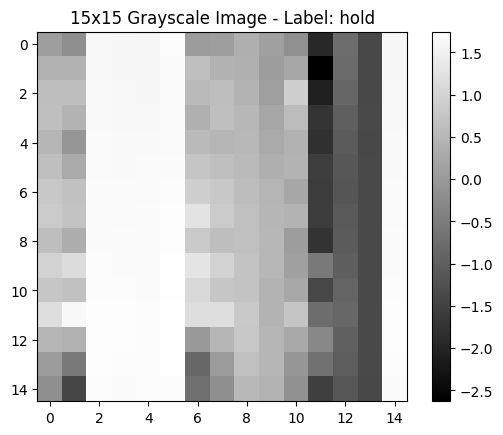

In [145]:
import matplotlib.pyplot as plt

def create_image(df, start_idx, end_idx):
    image_data = df.iloc[start_idx:end_idx, 5:20].values
    central_label = df.iloc[(start_idx + end_idx) // 2]['label']
    
    if image_data.shape != (15, 15):
        raise ValueError("Data for image is not 15x15")
    
    return image_data, central_label

def display_image(image_data, label):
    plt.imshow(image_data, cmap='gray', aspect='equal')
    plt.colorbar()
    plt.title(f"15x15 Grayscale Image - Label: {label}")
    plt.show()

def generate_images(df, window_size=15):
    images = []
    labels = []
    for i in range(len(df) - window_size + 1):
        image, label = create_image(df, i, i + window_size)
        images.append(image)
        labels.append(label)
    return images, labels

images, labels = generate_images(df)

print(pd.DataFrame(labels).shape)
display_image(images[158], labels[158])

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np

label_binarizer = LabelBinarizer()
labels_one_hot = label_binarizer.fit_transform(labels)

images = np.array(images)
images = images / 255.0

X_train, X_val, y_train, y_val = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)


In [147]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(15, 15, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming three classes: Buy, Hold, Sell
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/home/miikimikki/Documents/DL/Tugas3/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8414 - loss: 0.7220 - val_accuracy: 0.8602 - val_loss: 0.5118
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8786 - loss: 0.4676 - val_accuracy: 0.8602 - val_loss: 0.5013
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8817 - loss: 0.4573 - val_accuracy: 0.8602 - val_loss: 0.5027
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8822 - loss: 0.4549 - val_accuracy: 0.8602 - val_loss: 0.5016
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8720 - loss: 0.4847 - val_accuracy: 0.8602 - val_loss: 0.5050
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8761 - loss: 0.4721 - val_accuracy: 0.8602 - val_loss: 0.5024
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8765 - loss: 0.4713 - val_accuracy: 0.8602 - val_loss: 0.5024
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8833 - loss: 0.4528 - val_accu

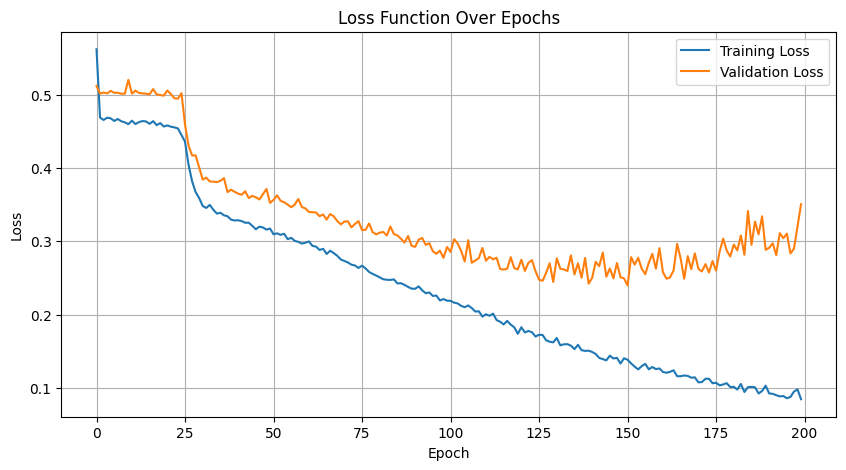

In [148]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

test_loss, test_acc = model.evaluate(X_val, y_val)
print(f'Test accuracy: {test_acc}')

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [149]:
from sklearn.metrics import classification_report

predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_val, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=label_binarizer.classes_))


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

         buy       0.71      0.52      0.60        69
        hold       0.93      0.97      0.95       843
        sell       0.76      0.57      0.66        68

    accuracy                           0.91       980
   macro avg       0.80      0.69      0.73       980
weighted avg       0.90      0.91      0.90       980

